In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

## Create Query

In [3]:
# rental join inventory join film - category
# to sum the rentals in May was Tom's Idea, and I think it is brilliant :)

query = '''select f.title, COUNT(i.inventory_id) AS num_of_copies, f.language_id, f.length, f.rating, f.special_features, f.rental_rate,SUM(CASE WHEN MONTH(r.rental_date) = 5 THEN 1 ELSE 0 END) AS num_rentals_in_may
from sakila.film f
left join inventory i
on f.film_id = i.film_id
left join rental r
on r.inventory_id = i.inventory_id
group by f.title, f.language_id, f.length, f.rating, f.special_features, f.rental_rate;'''

data = pd.read_sql_query(query, engine)
data


,title,num_of_copies,language_id,length,rating,special_features,rental_rate,num_rentals_in_may
0,ACADEMY DINOSAUR,24,1,86,PG,"Deleted Scenes,Behind the Scenes",0.99,2.0
1,ACE GOLDFINGER,7,1,48,G,"Trailers,Deleted Scenes",4.99,0.0
2,ADAPTATION HOLES,12,1,50,NC-17,"Trailers,Deleted Scenes",2.99,1.0
3,AFFAIR PREJUDICE,23,1,117,G,"Commentaries,Behind the Scenes",2.99,2.0
4,AFRICAN EGG,12,1,130,G,Deleted Scenes,2.99,1.0
...,...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,7,1,183,G,"Trailers,Behind the Scenes",0.99,0.0
996,YOUTH KICK,6,1,179,NC-17,"Trailers,Behind the Scenes",0.99,0.0
997,ZHIVAGO CORE,9,1,105,NC-17,Deleted Scenes,0.99,1.0
998,ZOOLANDER FICTION,17,1,101,R,"Trailers,Deleted Scenes",2.99,1.0


In [4]:
# Then I created the column to see which films were rented in May. Since I have the number for the rentals in May everything that has a 0 was not rented verything else was rented.

def rented_in_may(num_rentals):
    if num_rentals >= 1:
        return True
    else:
        return False
    
data['rented_in_may'] = data['num_rentals_in_may'].apply(rented_in_may)
data

,title,num_of_copies,language_id,length,rating,special_features,rental_rate,num_rentals_in_may,rented_in_may
0,ACADEMY DINOSAUR,24,1,86,PG,"Deleted Scenes,Behind the Scenes",0.99,2.0,True
1,ACE GOLDFINGER,7,1,48,G,"Trailers,Deleted Scenes",4.99,0.0,False
2,ADAPTATION HOLES,12,1,50,NC-17,"Trailers,Deleted Scenes",2.99,1.0,True
3,AFFAIR PREJUDICE,23,1,117,G,"Commentaries,Behind the Scenes",2.99,2.0,True
4,AFRICAN EGG,12,1,130,G,Deleted Scenes,2.99,1.0,True
...,...,...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,7,1,183,G,"Trailers,Behind the Scenes",0.99,0.0,False
996,YOUTH KICK,6,1,179,NC-17,"Trailers,Behind the Scenes",0.99,0.0,False
997,ZHIVAGO CORE,9,1,105,NC-17,Deleted Scenes,0.99,1.0,True
998,ZOOLANDER FICTION,17,1,101,R,"Trailers,Deleted Scenes",2.99,1.0,True


## Cleaning the data

In [5]:
#If I look at the dtypes everything looks as I would expect it.
data.dtypes

title                  object
num_of_copies           int64
language_id             int64
length                  int64
rating                 object
special_features       object
rental_rate           float64
num_rentals_in_may    float64
rented_in_may            bool
dtype: object

In [6]:
#There are no Null values.
data.isna().sum()

title                 0
num_of_copies         0
language_id           0
length                0
rating                0
special_features      0
rental_rate           0
num_rentals_in_may    0
rented_in_may         0
dtype: int64

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_of_copies,1000.0,16.045,7.349080,0.00,11.00,16.00,21.00,34.00
language_id,1000.0,1.000,0.000000,1.00,1.00,1.00,1.00,1.00
length,1000.0,115.272,40.426332,46.00,80.00,114.00,149.25,185.00
rental_rate,1000.0,2.980,1.646393,0.99,0.99,2.99,4.99,4.99
num_rentals_in_may,1000.0,1.156,1.053933,0.00,0.00,1.00,2.00,5.00


In [8]:
#It looks like there is just one langugae ID. Let's check.
data.language_id.value_counts()

language_id
1    1000
Name: count, dtype: int64

In [9]:
# Since all the movies just are in the same language I can drop this column
data = data.drop(['language_id'], axis=1)
data

,title,num_of_copies,length,rating,special_features,rental_rate,num_rentals_in_may,rented_in_may
0,ACADEMY DINOSAUR,24,86,PG,"Deleted Scenes,Behind the Scenes",0.99,2.0,True
1,ACE GOLDFINGER,7,48,G,"Trailers,Deleted Scenes",4.99,0.0,False
2,ADAPTATION HOLES,12,50,NC-17,"Trailers,Deleted Scenes",2.99,1.0,True
3,AFFAIR PREJUDICE,23,117,G,"Commentaries,Behind the Scenes",2.99,2.0,True
4,AFRICAN EGG,12,130,G,Deleted Scenes,2.99,1.0,True
...,...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,7,183,G,"Trailers,Behind the Scenes",0.99,0.0,False
996,YOUTH KICK,6,179,NC-17,"Trailers,Behind the Scenes",0.99,0.0,False
997,ZHIVAGO CORE,9,105,NC-17,Deleted Scenes,0.99,1.0,True
998,ZOOLANDER FICTION,17,101,R,"Trailers,Deleted Scenes",2.99,1.0,True


In [10]:
data.rental_rate.value_counts()

rental_rate
0.99    341
4.99    336
2.99    323
Name: count, dtype: int64

In [11]:
#Since there are just 3 categories I would make that a categorical variable
data['rental_rate'] = data['rental_rate'].astype('object')
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_of_copies,1000.0,16.045,7.349080,0.0,11.0,16.0,21.00,34.0
length,1000.0,115.272,40.426332,46.0,80.0,114.0,149.25,185.0
num_rentals_in_may,1000.0,1.156,1.053933,0.0,0.0,1.0,2.00,5.0


In [12]:
data.rating.value_counts()

rating
PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: count, dtype: int64

In [13]:
# Since it is just 5 categories I decide to keep all of them and not group them together.

In [14]:
data.special_features.value_counts()

special_features
Trailers,Commentaries,Behind the Scenes                   79
Trailers                                                  72
Trailers,Commentaries                                     72
Trailers,Behind the Scenes                                72
Deleted Scenes,Behind the Scenes                          71
Commentaries,Behind the Scenes                            70
Behind the Scenes                                         70
Trailers,Deleted Scenes                                   66
Commentaries,Deleted Scenes,Behind the Scenes             66
Commentaries,Deleted Scenes                               65
Trailers,Commentaries,Deleted Scenes                      64
Commentaries                                              62
Deleted Scenes                                            61
Trailers,Commentaries,Deleted Scenes,Behind the Scenes    61
Trailers,Deleted Scenes,Behind the Scenes                 49
Name: count, dtype: int64

In [15]:
#There are 4 categories that are put togehter in different ways, so I tried to encode it myself later on.


In [16]:
# I just realised I still have the title in the dataframe. Since this behaves a bit like an ID I want to drop it.

data = data.drop(['title'], axis=1)
data

,num_of_copies,length,rating,special_features,rental_rate,num_rentals_in_may,rented_in_may
0,24,86,PG,"Deleted Scenes,Behind the Scenes",0.99,2.0,True
1,7,48,G,"Trailers,Deleted Scenes",4.99,0.0,False
2,12,50,NC-17,"Trailers,Deleted Scenes",2.99,1.0,True
3,23,117,G,"Commentaries,Behind the Scenes",2.99,2.0,True
4,12,130,G,Deleted Scenes,2.99,1.0,True
...,...,...,...,...,...,...,...
995,7,183,G,"Trailers,Behind the Scenes",0.99,0.0,False
996,6,179,NC-17,"Trailers,Behind the Scenes",0.99,0.0,False
997,9,105,NC-17,Deleted Scenes,0.99,1.0,True
998,17,101,R,"Trailers,Deleted Scenes",2.99,1.0,True


## Train / Test Split

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

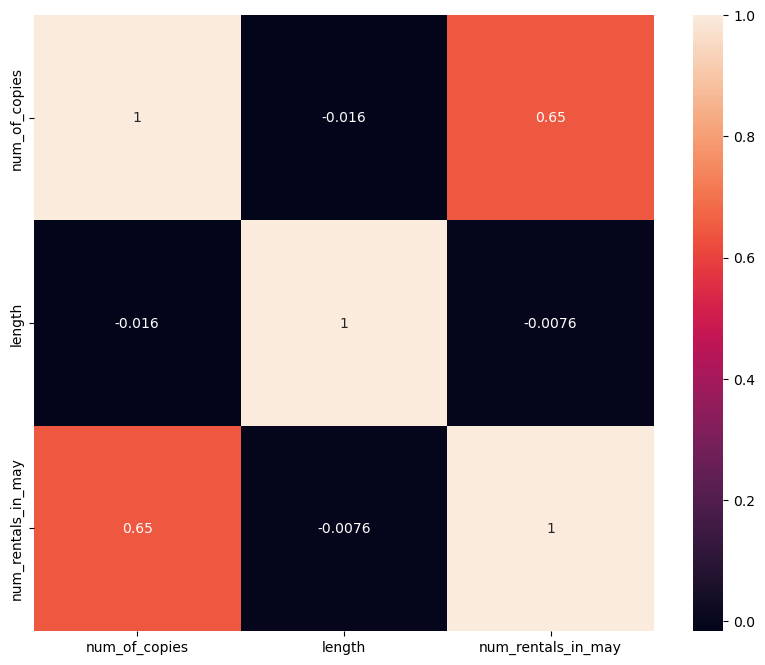

In [18]:
corr_matrix=data.select_dtypes('number').corr()  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [19]:
# There is a higher correlation between num_of_copies and num_rentals_in_may. But out of curiosity it something I still want to have in the Prediction.
# Maybe it is something I might want to drop later. Okay I saw that this will overfit the model, so I need to drop this column.

In [20]:
data = data.drop('num_rentals_in_may', axis=1)
data

,num_of_copies,length,rating,special_features,rental_rate,rented_in_may
0,24,86,PG,"Deleted Scenes,Behind the Scenes",0.99,True
1,7,48,G,"Trailers,Deleted Scenes",4.99,False
2,12,50,NC-17,"Trailers,Deleted Scenes",2.99,True
3,23,117,G,"Commentaries,Behind the Scenes",2.99,True
4,12,130,G,Deleted Scenes,2.99,True
...,...,...,...,...,...,...
995,7,183,G,"Trailers,Behind the Scenes",0.99,False
996,6,179,NC-17,"Trailers,Behind the Scenes",0.99,False
997,9,105,NC-17,Deleted Scenes,0.99,True
998,17,101,R,"Trailers,Deleted Scenes",2.99,True


In [21]:
# Need to X-y split and train-test-split BEFORE I apply transformations,
# then train transformation on training set only
y = data['rented_in_may']
X = data.drop('rented_in_may', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

## Scaling / Encoding

In [22]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns=X_train_num.columns)
X_train_norm

,num_of_copies,length
0,0.235294,0.769784
1,0.705882,0.151079
2,0.588235,0.258993
3,0.852941,0.223022
4,0.470588,0.733813
...,...,...
795,0.176471,0.151079
796,0.558824,0.683453
797,0.617647,0.467626
798,0.411765,0.906475


In [23]:
X_train_categorical = X_train.select_dtypes(include = object)

# Since I want to do two seperate  encoding methods I seperate the X_train_categorical data

X_train_cat_1 = X_train_categorical[['special_features']]
X_train_cat_2 = X_train_categorical.drop(['special_features'], axis=1)



In [24]:
# As I said I would like to encode the Special Features on my own.
X_train_cat_1['Trailers'] = None
X_train_cat_1['Commentaries'] = None
X_train_cat_1['Deleted Scenes'] = None
X_train_cat_1['Behind the Scenes'] = None
X_train_cat_1

C:\Users\hanne\AppData\Local\Temp\ipykernel_13980\3163863334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_cat_1['Trailers'] = None


,special_features,Trailers,Commentaries,Deleted Scenes,Behind the Scenes
46,Commentaries,None,None,None,None
789,Trailers,None,None,None,None
722,"Deleted Scenes,Behind the Scenes",None,None,None,None
283,Trailers,None,None,None,None
39,"Trailers,Commentaries",None,None,None,None
...,...,...,...,...,...
167,"Trailers,Behind the Scenes",None,None,None,None
232,"Trailers,Deleted Scenes,Behind the Scenes",None,None,None,None
860,Commentaries,None,None,None,None
189,"Trailers,Behind the Scenes",None,None,None,None


In [25]:
for category in ['Trailers', 'Commentaries', 'Deleted Scenes', 'Behind the Scenes']:
    X_train_cat_1[category] = X_train_cat_1['special_features'].apply(lambda x: 1 if category in x else 0)

X_train_cat_1

,special_features,Trailers,Commentaries,Deleted Scenes,Behind the Scenes
46,Commentaries,0,1,0,0
789,Trailers,1,0,0,0
722,"Deleted Scenes,Behind the Scenes",0,0,1,1
283,Trailers,1,0,0,0
39,"Trailers,Commentaries",1,1,0,0
...,...,...,...,...,...
167,"Trailers,Behind the Scenes",1,0,0,1
232,"Trailers,Deleted Scenes,Behind the Scenes",1,0,1,1
860,Commentaries,0,1,0,0
189,"Trailers,Behind the Scenes",1,0,0,1


In [26]:
#After that I can drop the special_features column

X_train_cat_1 = X_train_cat_1.drop(['special_features'], axis=1)
X_train_cat_1

,Trailers,Commentaries,Deleted Scenes,Behind the Scenes
46,0,1,0,0
789,1,0,0,0
722,0,0,1,1
283,1,0,0,0
39,1,1,0,0
...,...,...,...,...
167,1,0,0,1
232,1,0,1,1
860,0,1,0,0
189,1,0,0,1


In [27]:
# Then I use OneHot Encoder for the other two columns
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first').fit(X_train_cat_2)
cols = encoder.get_feature_names_out(input_features=X_train_cat_2.columns)
X_cat_encode = pd.DataFrame(encoder.transform(X_train_cat_2).toarray(),columns=cols)
X_cat_encode.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,rental_rate_2.99,rental_rate_4.99
0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
# Then we put the train data all back together

X_train_transformed = np.concatenate([X_train_normalized, X_train_cat_1, X_cat_encode], axis=1)
X_train_transformed

array([[0.23529412, 0.76978417, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.70588235, 0.15107914, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.58823529, 0.25899281, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.61764706, 0.4676259 , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.41176471, 0.90647482, 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.44117647, 0.31654676, 1.        , ..., 0.        , 1.        ,
        0.        ]])

In [29]:
# Let's train the model
from sklearn.linear_model import LogisticRegression 
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [30]:
# Now we have to change the Test data, too.
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized, columns=X_test_num.columns)
X_test_norm

,num_of_copies,length
0,0.264706,0.374101
1,0.411765,0.964029
2,0.617647,0.316547
3,0.000000,0.618705
4,0.882353,0.453237
...,...,...
195,0.500000,0.402878
196,0.558824,0.446043
197,0.764706,0.273381
198,0.617647,0.294964


In [31]:
# for categoricals
X_test_categorical = X_test.select_dtypes(include = object)
X_test_categorical

X_test_cat_1 = X_test_categorical[['special_features']]
X_test_cat_2 = X_test_categorical.drop(['special_features'], axis=1)

In [32]:
X_test_cat_1['Trailers'] = None
X_test_cat_1['Commentaries'] = None
X_test_cat_1['Deleted Scenes'] = None
X_test_cat_1['Behind the Scenes'] = None
X_test_cat_1

C:\Users\hanne\AppData\Local\Temp\ipykernel_13980\1625025136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_cat_1['Trailers'] = None


,special_features,Trailers,Commentaries,Deleted Scenes,Behind the Scenes
977,"Deleted Scenes,Behind the Scenes",None,None,None,None
15,"Trailers,Commentaries",None,None,None,None
56,Deleted Scenes,None,None,None,None
801,"Trailers,Commentaries,Deleted Scenes",None,None,None,None
747,"Trailers,Commentaries,Deleted Scenes,Behind th...",None,None,None,None
...,...,...,...,...,...
736,"Trailers,Commentaries,Deleted Scenes,Behind th...",None,None,None,None
369,"Deleted Scenes,Behind the Scenes",None,None,None,None
470,"Trailers,Commentaries",None,None,None,None
806,"Deleted Scenes,Behind the Scenes",None,None,None,None


In [33]:
for category in ['Trailers', 'Commentaries', 'Deleted Scenes', 'Behind the Scenes']:
    X_test_cat_1[category] = X_test_cat_1['special_features'].apply(lambda x: 1 if category in x else 0)
    
X_test_cat_1 = X_test_cat_1.drop(['special_features'], axis=1)

X_test_cat_1

,Trailers,Commentaries,Deleted Scenes,Behind the Scenes
977,0,0,1,1
15,1,1,0,0
56,0,0,1,0
801,1,1,1,0
747,1,1,1,1
...,...,...,...,...
736,1,1,1,1
369,0,0,1,1
470,1,1,0,0
806,0,0,1,1


In [34]:
X_cat_encode_2 = pd.DataFrame(encoder.transform(X_test_cat_2).toarray(),columns=cols)
X_cat_encode_2

,rating_NC-17,rating_PG,rating_PG-13,rating_R,rental_rate_2.99,rental_rate_4.99
0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,1.0,1.0,0.0
197,1.0,0.0,0.0,0.0,1.0,0.0
198,1.0,0.0,0.0,0.0,0.0,0.0


In [35]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat_1, X_cat_encode_2], axis=1)
X_test_transformed

array([[0.26470588, 0.37410072, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.41176471, 0.96402878, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.61764706, 0.31654676, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.76470588, 0.27338129, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.61764706, 0.29496403, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.32352941, 0.4028777 , 0.        , ..., 1.        , 0.        ,
        1.        ]])

## Predictions

In [36]:
#now we can make predictions
predictions = classification.predict(X_test_transformed)
predictions
classification.score(X_test_transformed, y_test)

0.775

In [38]:
print(y_test.value_counts())

rented_in_may
True     138
False     62
Name: count, dtype: int64


In [39]:
pd.Series(predictions).value_counts()

True     153
False     47
Name: count, dtype: int64

In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[ 32,  30],
       [ 15, 123]], dtype=int64)

In [ ]:
# predicted     | False | True | 
# ------------------------------
# actual  False |   +  |      |   
# ------------------------------
#         True |       |  +   |  
# -----------------------------


In [ ]:
# The dataset is quite imbalanced because we have way more films that were rented than ones that were not rented.
# We predicted 32 films that were not rented and 123 films that were rented right. We predicted 45 films wrong in the end.